In [1]:
import os
import numpy as np
import math
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import collections
import pickle

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels =32, kernel_size= 4, stride = 2, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels =64, kernel_size= 4, stride = 2, padding = 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size= 4, stride = 2, padding = 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size= 4, stride = 2, padding = 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size= 4, stride = 2, padding = 1)

    def forward(self,x):
        num_images = x.shape[0]
        x = F.leaky_relu(self.bn1(self.conv1(x)),negative_slope=0.2)
        x =  F.leaky_relu(self.bn2(self.conv2(x)),negative_slope=0.2)
        x =  F.leaky_relu(self.bn3(self.conv3(x)),negative_slope=0.2)
        x =  F.leaky_relu(self.bn4(self.conv4(x)),negative_slope=0.2)
        x = self.conv5(x)
        return x.reshape(num_images,1)

class Generator(nn.Module):
  #100 dimensional uniform distribution Z is input from Figure 1 of the paper
  #First layer should have depth 1024. 1024/32 = 32
    def __init__(self):
        super().__init__()
        self.upscale1 = nn.ConvTranspose2d(in_channels=100, out_channels=1024,kernel_size=4,stride = 1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.upscale2 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,kernel_size=4,stride = 2,padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.upscale3 = nn.ConvTranspose2d(in_channels=512, out_channels=256,kernel_size=4,stride = 2,padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.upscale4 = nn.ConvTranspose2d(in_channels=256, out_channels=3,kernel_size=4,stride = 2,padding=1)
    def forward(self,x):
        x = F.relu(self.bn1(self.upscale1(x)))
        x = F.relu(self.bn2(self.upscale2(x)))
        x = F.relu(self.bn3(self.upscale3(x)))
        x = torch.tanh(self.upscale4(x))
        return x

In [3]:
num_chanels = 3 #num channels (RBG)
num_images =26
dim = 32 #dim of CIFAR10 dataset = 32x32 images
rand_image = torch.randn(num_images,num_chanels,dim,dim)
net = Discriminator()
out = net(rand_image)
#Checks to see if output are correct shape
print(list(out.shape))
if (list(out.shape) == [num_images,1]):
    print("The output is of correct shape")

[26, 1]
The output is of correct shape


In [4]:
num_chanels = 100 #num channels (RBG)
num_images =10
dim = 1 #dim of CIFAR10 dataset = 32x32 images
rand_image = torch.randn(num_images,num_chanels,dim,dim)
net = Generator()
out = net(rand_image)
#Checks to see if output are correct shape
print(list(out.shape))

[10, 3, 32, 32]


In [5]:
discriminator = Discriminator().cuda()
for layer in discriminator.modules():
      if isinstance(layer,nn.Conv2d):
        nn.init.normal_(layer.weight.data,0,0.02)

generator = Generator().cuda()
for layer in discriminator.modules():
      if isinstance(layer,nn.ConvTranspose2d):
        nn.init.normal_(layer.weight.data,0,0.02)

In [6]:
def sample_image_norm(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = torch.randn(n_row, 100, 1, 1).cuda()
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = torch.as_tensor(torch.LongTensor(labels))
    #can turn off gradient computation to run
    with torch.no_grad():
        gen_imgs = generator(z)
    save_image(gen_imgs.data, "WGAN_images_norm/%d.png" % batches_done, normalize=True)

def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = torch.randn(n_row, 100, 1, 1).cuda()
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = torch.as_tensor(torch.LongTensor(labels))
    #can turn off gradient computation to run
    with torch.no_grad():
        gen_imgs = generator(z)
    #set normalization to False
    save_image(gen_imgs.data, "WGAN_images/%d.png" % batches_done, normalize=False)

In [7]:
os.makedirs("WGAN_images", exist_ok=True)
os.makedirs("WGAN_images_norm", exist_ok=True)
os.makedirs("WGAN_data", exist_ok=True)
os.makedirs("WGAN_model", exist_ok=True)
os.makedirs("WGAN_GEN_WEIGHTS", exist_ok=True)
os.makedirs("WGAN_GEN_GRADS", exist_ok=True)
os.makedirs("WGAN_DISC_GRADS", exist_ok=True)

In [8]:
#set hyperparameters and Normalization
sample_interval=391
NUM_EPOCHS = 200

sample_interval=391
NUM_EPOCHS = 200
alpha = 5e-5
batch_size = 64
n_critic=5
c = 0.01

optimizer_gen= optim.RMSprop(generator.parameters(), lr=alpha)
optimizer_disc = optim.RMSprop(discriminator.parameters(), lr=alpha)
transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])

dataset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [9]:
loss_g_list=[]
loss_d_list=[]

#set models to train 
generator.train()
discriminator.train()
print("Ready to Run!")

#run loop
for epoch in range(NUM_EPOCHS):
    grad_dict = collections.defaultdict(list)
    torch.save(generator,"WGAN_GEN_WEIGHTS/weights" + str(epoch) + ".pt")
#     torch.save(optimizer_gen.state_dict(), "WGAN_GEN_GRADS/GradientsGen" + str(epoch) + ".pt")
#     torch.save(optimizer_disc.state_dict(), "WGAN_GEN_DISC_GRADS/GradientsDisc" + str(epoch) + ".pt")


    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.cuda() #get real images

        for k in range(n_critic):
            ### Train Discriminator
            
            noise = torch.randn(batch_size, 100, 1, 1).cuda()
            fake = generator(noise)
            disc_real = discriminator(real).reshape(-1)
            disc_fake = discriminator(fake).reshape(-1)
            loss_disc= -(torch.mean(disc_real) - torch.mean(disc_fake))
            discriminator.zero_grad() #zero gradients 
            loss_disc.backward(retain_graph=True) #backpropagation
            optimizer_disc.step()
        
            for params in discriminator.parameters():
                params.data.clamp_(-c, c)

        ### Train Generator
        output = discriminator(fake).reshape(-1) #have discriminator classify fake 
        loss_gen = -torch.mean(output)
        generator.zero_grad() #zero gradients 
        loss_gen.backward() #backpropagation
        optimizer_gen.step()
        

        #below jsut saves some data 
        batches_done = epoch * len(dataloader) + batch_idx
        if batches_done % sample_interval == 0:
            sample_image_norm(n_row=64, batches_done=batches_done)
            sample_image(n_row=64, batches_done=batches_done)
            torch.save({
            'epoch': epoch,
            #'model_state_dict': generator.state_dict(),
            #'optimizer_state_dict': optimizer_gen.state_dict(),
            'loss_gen': loss_gen,
            'loss_disc': loss_disc,
            }, "./WGAN_model/model"+str(epoch)+".pth")
    
    #add loss to lists for later plotting
    loss_g_list.append(loss_gen)
    loss_d_list.append(loss_disc)
    
    for layer in discriminator.modules():
        if isinstance(layer, nn.Conv2d):
            grad = layer.weight.grad.cpu().numpy()
            num_weights = (np.abs(grad) < 0.1).sum()
            mean = np.mean(grad)
            std = np.std(grad)
            val = [mean,std,num_weights]
            grad_dict[epoch].append(val)
            
    with open('grad_dict' + str(epoch) + '.pkl', 'wb') as f:
        pickle.dump(grad_dict, f)
        
    #print what epoch we are on 
    print(
          "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
           % (epoch, NUM_EPOCHS, loss_disc.item(), loss_gen.item())
          )
    generator.train()
    discriminator.train()

Ready to Run!


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[Epoch 0/200] [D loss: -0.157786] [G loss: 0.072773]
[Epoch 1/200] [D loss: -0.186499] [G loss: 0.082615]
[Epoch 2/200] [D loss: -0.187309] [G loss: 0.082631]
[Epoch 3/200] [D loss: -0.187137] [G loss: 0.082456]
[Epoch 4/200] [D loss: -0.187919] [G loss: 0.082997]
[Epoch 5/200] [D loss: -0.187628] [G loss: 0.082841]
[Epoch 6/200] [D loss: -0.186855] [G loss: 0.082281]
[Epoch 7/200] [D loss: -0.188080] [G loss: 0.083066]
[Epoch 8/200] [D loss: -0.188300] [G loss: 0.083047]
[Epoch 9/200] [D loss: -0.186761] [G loss: 0.082228]
[Epoch 10/200] [D loss: -0.188151] [G loss: 0.082943]
[Epoch 11/200] [D loss: -0.005086] [G loss: -0.093622]
[Epoch 12/200] [D loss: -0.187302] [G loss: 0.082401]
[Epoch 13/200] [D loss: -0.185084] [G loss: 0.081208]
[Epoch 14/200] [D loss: -0.061353] [G loss: 0.042743]
[Epoch 15/200] [D loss: -0.187918] [G loss: 0.082973]
[Epoch 16/200] [D loss: -0.187583] [G loss: 0.082595]
[Epoch 17/200] [D loss: -0.188333] [G loss: 0.083081]
[Epoch 18/200] [D loss: -0.185061] [G

RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 2.69 GiB total capacity; 1.80 GiB already allocated; 0 bytes free; 1.90 GiB reserved in total by PyTorch)

In [10]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

<Figure size 432x288 with 0 Axes>

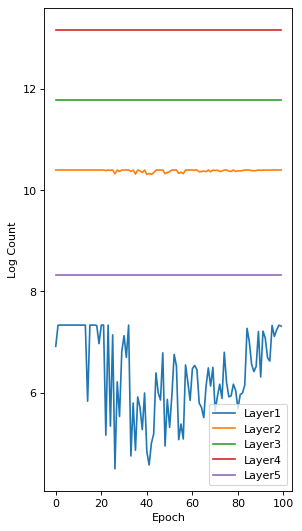

In [11]:
plt.figure()
vals = []
layer = []
layer_val = []
epoch_vals = 100
num_layers = 5
plt.figure(figsize=(4, 8), dpi=80)
for layer in range(num_layers):
    if layer < 5:
        layer_val = []
        for epoch in range(epoch_vals):
              with open('grad_dict' + str(epoch) + '.pkl', 'rb') as f:
                loaded_dict = pickle.load(f)
                for key in (loaded_dict):
                    layer_val.append(loaded_dict[key][layer][2])
        plt.plot(list(range(epoch_vals)),np.log(layer_val),label = "ConvLayer" + str(layer + 1))
        plt.xlabel("Epoch")
        plt.ylabel("Log Count")
        plt.legend()
       
#plt.plot(list(range(0,200)),vals)
plt.savefig('GradientCount.png')
plt.show()